In [1]:
import os
batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
import jax
num_cores = jax.local_device_count()
import inference_gym.using_jax as gym


import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns

2025-05-30 08:14:22.858750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748618063.046927 1853567 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748618063.085529 1853567 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Drawing from a sampler

Suppose we want to draw samples from the Banana distribution, using the No-U-Turn Sampler. We proceed as follows:

In [2]:
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error


model=banana()

samples, metadata = samplers['nuts'](return_samples=True)(
        model=gym.targets.Banana(), 
        num_steps=10000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(2,)), 
        key=jax.random.key(0))


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/global/homes/r/reubenh/.conda/envs/jax2024/lib/

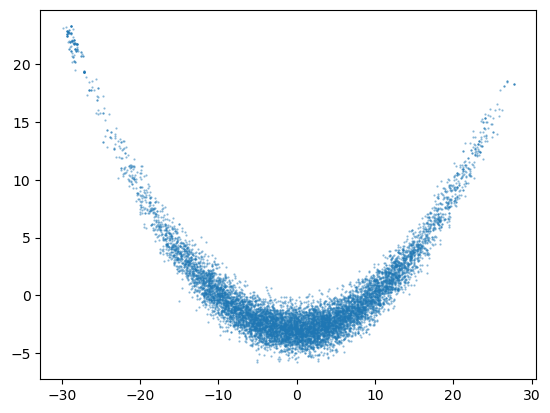

In [3]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)

## Running multiple chains

Often we want to run multiple chains in parallel. In Jax, this can be done as follows:

In [4]:
batch_size = 128

init_keys = jax.random.split(jax.random.key(3), batch_size)

keys = jax.random.split(jax.random.key(3), batch_size)

initial_position = jax.vmap(lambda key: initialize_model(model, key))(init_keys)

num_steps = 20000

samples, metadata = jax.pmap(
        lambda key, pos: samplers['nuts'](return_samples=True)(
        model=model, num_steps=num_steps, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/goog

## Analysing the efficiency of the sampler

To analyse the efficiency of the sampler, we can calculate the *standardized squared error* of $x^2$ and $x$,  respectively defined as:

$\frac{(E_{\mathit{sampler}}[x^2]-E[x^2])^2}{Var[x^2]}$ and $\frac{(E_{\mathit{sampler}}[x]-E[x])^2}{Var[x]}$, where $E_{\mathit{sampler}}$ is the empirical estimate of the expectation. We can then count how many steps of the kernel (and in particular for gradient based samplers, how many gradient calls), it takes for these statistics to drop below a threshold (by default $0.01$). In code:

In [5]:
samples.shape

(128, 20000, 2)

In [7]:

error_at_each_step = jnp.nanmedian(get_standardized_squared_error(
    samples, 
    f=model.sample_transformations["square"],
    E_f=model.sample_transformations["square"].ground_truth_mean,
    Var_f=model.sample_transformations["square"].ground_truth_standard_deviation**2
    ),axis=0)

gradient_calls_per_proposal = metadata['num_grads_per_proposal'].mean()

samples_to_low_err = samples_to_low_error(error_at_each_step) * gradient_calls_per_proposal

print("Gradient calls to low error", samples_to_low_err)

final error is 0.006967142689973116
Gradient calls to low error 107792.96


## Effective sample size (ESS)

We can also calculate ESS, either by the reciprocal of the number of gradient calls to low error, or via an estimate of the autocorrelation time. In code:

In [8]:
from blackjax.diagnostics import effective_sample_size


ess_correlation = jnp.min(effective_sample_size(samples)) / (num_steps * gradient_calls_per_proposal)
ess_bias = 100 / samples_to_low_err

print("Ess by bias:", ess_bias)
print("Ess by correlation:", ess_correlation)

Ess by bias: 0.0009277044
Ess by correlation: 0.047046237


## Streaming averages, for large models

For models with many parameters (that is, high dimensional distributions), the array of samples, of shape `[batch_size, num_samples, num_dimensions]`, can be too large to fit in memory. However, all we need to keep at each step is a streaming average of the expectations $\mathbb{E}[x]$ and $\mathbb{E}[x^2]$, and return an array of the standarized squared errors at each step, of shape `[num_samples]`.

This is done as follows:

In [11]:
squared_errors, metadata = jax.pmap(
        lambda key, pos: samplers['nuts'](return_samples=False)(
        model=model, num_steps=20000, initial_position=pos, key=key
        )
        )(
        keys,
        initial_position,
        )

err_t_max_x2 = jnp.median(squared_errors['square']['max'], axis=0)
samples_to_low_max_x2 = samples_to_low_error(
err_t_max_x2)* metadata["num_grads_per_proposal"].mean()

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/goog

final error is 0.006967106368392706


## Inspecting benchmark results

This repository provides precalculated results of measuring the efficiency of a range of samplers on a range of models. These results can be viewed as follows:

In [18]:
import itertools
import os
import pandas as pd
from sampler_comparison.samplers import samplers
from sampler_evaluation.models.banana import banana
from sampler_evaluation.models.brownian import brownian_motion
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_evaluation.models.german_credit import german_credit
from sampler_evaluation.models.stochastic_volatility import stochastic_volatility
from sampler_evaluation.models.stochastic_volatility_mams_paper import stochastic_volatility_mams_paper
from sampler_evaluation.models.item_response import item_response
from sampler_evaluation.models.rosenbrock import Rosenbrock
from sampler_evaluation.models.neals_funnel import neals_funnel
from sampler_evaluation.models.banana_mams_paper import banana_mams_paper
from sampler_comparison.samplers import samplers

models = [
    # banana(),
    brownian_motion(),
    german_credit(),
    Rosenbrock(),
    # stochastic_volatility_mams_paper,
    item_response(),
]

models = {
    # "Banana": banana(),
    # "Brownian_Motion": brownian_motion(),
    # "German_Credit": german_credit(),
    # "Rosenbrock": Rosenbrock(),
    # # "Neals_Funnel": neals_funnel(),
    # "Stochastic_Volatility": stochastic_volatility(),
    # "Item_Response": item_response(),

    model.name: model

    for model in models
}


# models = {
#     # "Banana_MAMS_Paper": banana_mams_paper,
#     banana().name: banana(),
#     # "Gaussian_MAMS_Paper": IllConditionedGaussian(ndims=100, condition_number=100, eigenvalues='log'),
#     brownian_motion().name: brownian_motion(),
#     # "German_Credit": german_credit(),
#     # "Rosenbrock": Rosenbrock(),
#     # "Neals_Funnel_MAMS_Paper": neals_funnel(),
#     # "Stochastic_Volatility_MAMS_Paper": stochastic_volatility_mams_paper,
#     # "Item_Response": item_response(),
# }

# samplers = {"nuts", "adjusted_microcanonical", ""}

df = pd.concat([pd.read_csv(os.path.join('../..',f'results/{model}', f'{sampler}_{model}.csv')) for sampler, model in itertools.product(samplers, models)], ignore_index=True)

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    new_df = df[(df['max']==True) & (df['statistic']=='square')]
    # display numbers without scientific notation
    # new_df = new_df[df['Model']=='banana']
    pd.set_option('display.float_format', '{:.2f}'.format)
    display(new_df)

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,ess_corr,max,statistic,num_tuning_grads,L,step_size
2,2,adjusted_hmc,vector_brownian_motion_unknown_scales_missing_...,17379.49,NaN,True,square,193968.50,2.00,0.18
6,2,adjusted_hmc,vector_german_credit_numeric_sparse_logistic_r...,56453.92,NaN,True,square,637300.35,1.97,0.05
10,2,adjusted_hmc,rosenbrock_36d,95042.79,NaN,True,square,902614.69,2.00,0.04
14,2,adjusted_hmc,vector_synthetic_item_response_theory,44356.63,NaN,True,square,265941.53,1.41,0.13
18,2,nuts,vector_brownian_motion_unknown_scales_missing_...,31052.17,NaN,True,square,103634.47,4.41,0.19
22,2,nuts,vector_german_credit_numeric_sparse_logistic_r...,74809.59,NaN,True,square,344178.78,3.97,0.06
26,2,nuts,rosenbrock_36d,160974.99,NaN,True,square,519500.80,5.35,0.04
30,2,nuts,vector_synthetic_item_response_theory,75578.00,NaN,True,square,151195.48,3.70,0.12
34,2,adjusted_microcanonical,vector_brownian_motion_unknown_scales_missing_...,13638.99,NaN,True,square,187271.85,11.31,1.09
38,2,adjusted_microcanonical,vector_german_credit_numeric_sparse_logistic_r...,55341.56,NaN,True,square,634560.26,14.11,0.38


/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

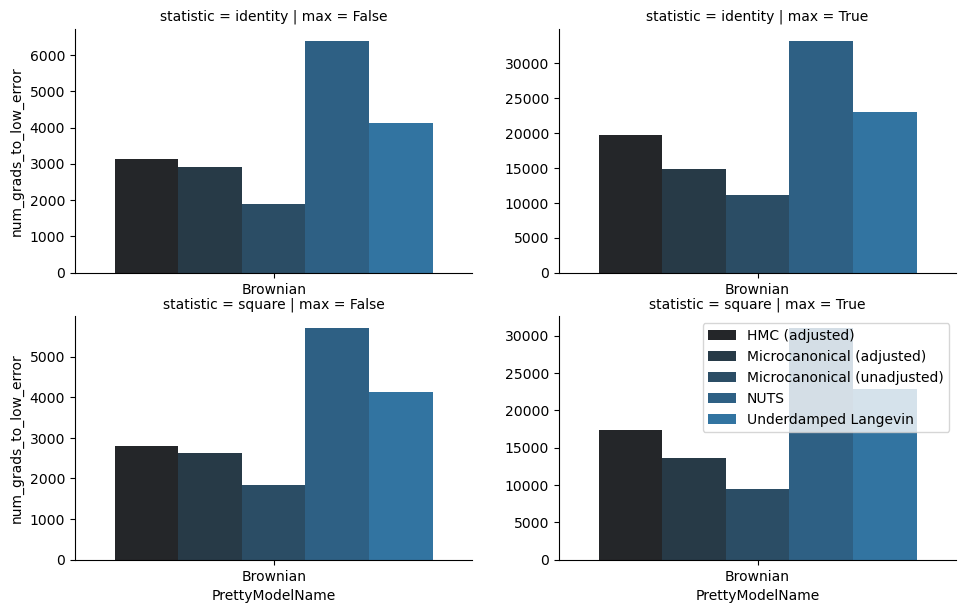

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

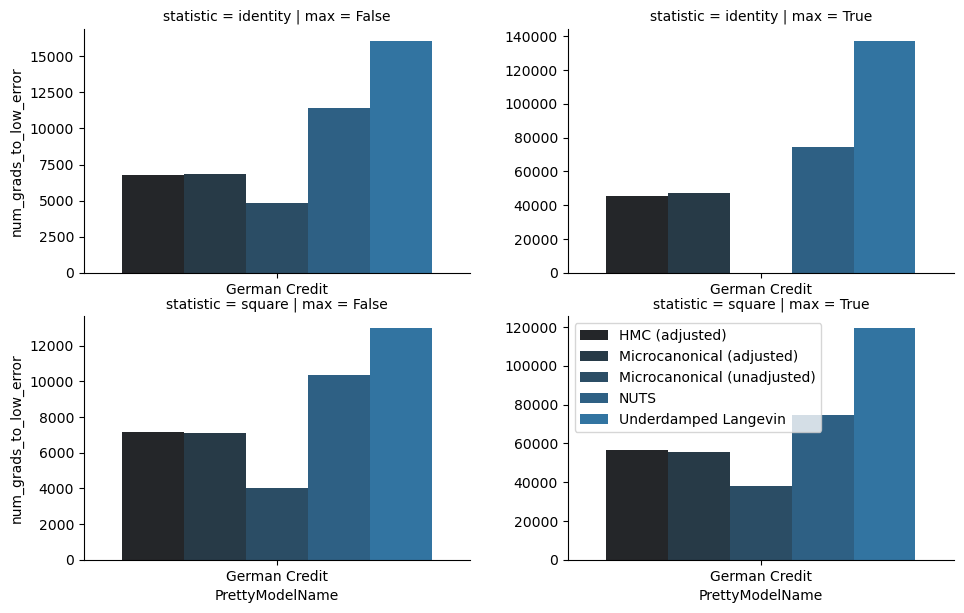

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

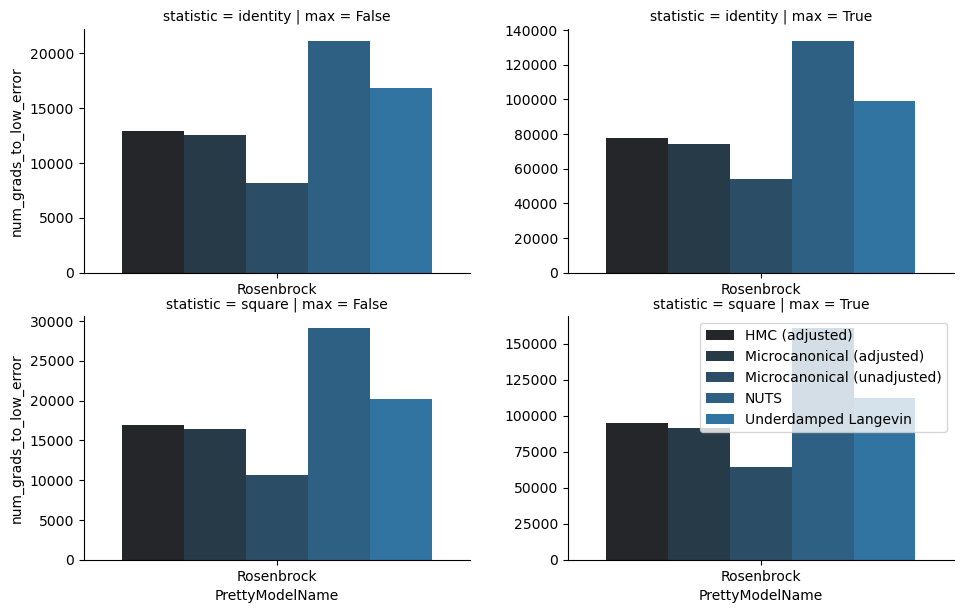

/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/tensorflow_probability/python/internal/backend/jax/numpy_array.py:531: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  lambda shape, dtype=np.float32, name=None, layout=None: np.zeros(  # pylint: disable=g-long-lambda
/global/homes/r/reubenh/.conda/envs/jax2024/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.a

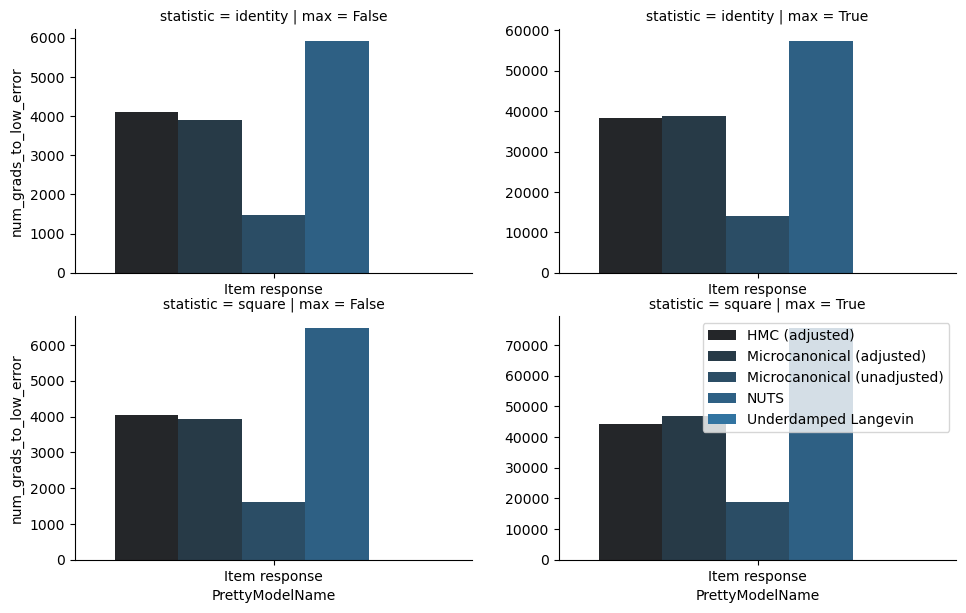

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sampler_evaluation

def display_results(model_name,df, include_tuning=False):

  df["PrettyName"] = df["Sampler"].apply({
    "nuts": "NUTS", 
    "unadjusted_microcanonical": "Microcanonical (unadjusted)",
    "adjusted_microcanonical": "Microcanonical (adjusted)",
    "underdamped_langevin" : "Underdamped Langevin",
    "adjusted_microcanonical_langevin" : "MAMS Langevin (adjusted)",
    "adjusted_hmc" : "HMC (adjusted)",
    }.get)
  df["total_num_grads_to_low_error"] = df["num_grads_to_low_error"] + df["num_tuning_grads"]
  df["PrettyModelName"] = df["Model"].apply({
    banana().name: "Banana",
    brownian_motion().name: "Brownian",
    german_credit().name: "German Credit",
    Rosenbrock().name: "Rosenbrock",
    stochastic_volatility_mams_paper.name: "Stochastic volatility",
    sampler_evaluation.models.item_response().name: "Item response",
    }.get)
  df = df[df["Model"] == model_name]

  g = sns.FacetGrid(df,
              col='max',
              row="statistic",
              sharex=False,
              sharey=False,
              height=4,
             )
  g = g.map(sns.barplot, 'PrettyModelName',  'total_num_grads_to_low_error' if include_tuning else "num_grads_to_low_error", "PrettyName",  
            hue_order=np.unique(df["PrettyName"]), 
            order=np.unique(df["PrettyModelName"]),
            # log_scale=True,
            palette='dark:#1f77b4'
  )
  plt.legend()
  plt.gcf().set_size_inches(10, 6)
  plt.show()

for model in models:
  display_results(model, df, include_tuning=False)

In [62]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,max,statistic,num_tuning_grads,L,step_size
0,0,adjusted_microcanonical,Banana_MAMS_Paper,1.407867e+04,True,x2,1.529316e+05,2.828427,0.177159
1,1,adjusted_microcanonical,Banana_MAMS_Paper,8.247459e+03,False,x2,1.529316e+05,2.828427,0.177159
2,2,adjusted_microcanonical,Banana_MAMS_Paper,inf,True,x,1.529316e+05,2.828427,0.177159
3,3,adjusted_microcanonical,Banana_MAMS_Paper,inf,False,x,1.529316e+05,2.828427,0.177159
4,0,adjusted_microcanonical,Gaussian_MAMS_Paper,3.249524e+03,True,x2,7.299984e+04,10.291699,5.596306
5,1,adjusted_microcanonical,Gaussian_MAMS_Paper,4.342512e+02,False,x2,7.299984e+04,10.291699,5.596306
6,2,adjusted_microcanonical,Gaussian_MAMS_Paper,4.414274e+03,True,x,7.299984e+04,10.291699,5.596306
7,3,adjusted_microcanonical,Gaussian_MAMS_Paper,5.704147e+02,False,x,7.299984e+04,10.291699,5.596306
8,0,adjusted_microcanonical,Brownian_Motion,1.352831e+04,True,x2,1.862522e+05,11.313708,1.086937
9,1,adjusted_microcanonical,Brownian_Motion,2.797522e+03,False,x2,1.862522e+05,11.313708,1.086937


In [1]:
# from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
import os
import jax
jax.config.update("jax_enable_x64", True)

batch_size = 512
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
num_cores = jax.local_device_count()


from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import (
    adjusted_mclmc,
)
from functools import partial
# import sys
# sys.path.append("../sampler-comparison/src/inference-gym/spinoffs/inference_gym")
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
import pandas as pd
from sampler_evaluation.models.banana import banana
import os
from results.run_benchmarks import run_benchmarks
# import sampler_evaluation
from sampler_evaluation.models.dirichlet import Dirichlet
import jax
from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import (
    adjusted_mclmc,
)
from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_comparison.samplers.microcanonicalmontecarlo.unadjusted import unadjusted_mclmc
from functools import partial
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc
from sampler_comparison.samplers.hamiltonianmontecarlo.unadjusted.underdamped_langevin import unadjusted_lmc
from sampler_comparison.samplers.microcanonicalmontecarlo.mchmc import unadjusted_mchmc
from sampler_comparison.samplers.hamiltonianmontecarlo.unadjusted.hmc import unadjusted_hmc

# model = gym.targets.dirichlet(dtype=jax.numpy.float64)

# model = Dirichlet()


# model = IllConditionedGaussian(ndims=100, condition_number=1, eigenvalues='log')



def lookup_results(model, mh : bool, canonical : bool, langevin : bool, tuning : str, integrator_type : str, diagonal_preconditioning : bool, redo : bool):
    
    integrator_name = integrator_type.replace('_', ' ')

    # make a dictionary that maps choice of parameters to a sampler. e.g. mh=True, canonical=True, tuning='none' -> 'nuts'
    sampler_dict = {
        # (True, True, True, 'nuts'): None,
        # (True, True, False, 'nuts'): (f'nuts_{integrator_type}', partial(nuts, integrator_type=integrator_type)),



        # adjusted/unadjusted  canonical/microcanonical  langevin/  alba
        (True, True, True, 'alba'): (f'adjusted_canonical_langevin_alba_{integrator_name}_precond:{diagonal_preconditioning}', partial(adjusted_hmc,num_tuning_steps=500, integrator_type=integrator_type, L_proposal_factor=1.25,diagonal_preconditioning=diagonal_preconditioning)),

        (True, True, False, 'alba'): (f'adjusted_canonical_nolangevin_alba_{integrator_name}_precond:{diagonal_preconditioning}', partial(adjusted_hmc,num_tuning_steps=500, integrator_type=integrator_type, L_proposal_factor=jnp.inf,diagonal_preconditioning=diagonal_preconditioning)),

        (True, False, True, 'alba'): (f'adjusted_microcanonical_langevin_alba_{integrator_name}_precond:{diagonal_preconditioning}', partial(adjusted_mclmc,L_proposal_factor=5.0, random_trajectory_length=True, L_factor_stage_3=0.23, num_tuning_steps=500,diagonal_preconditioning=diagonal_preconditioning, integrator_type=integrator_type)),

        (True, False, False, 'alba'): (f'adjusted_microcanonical_nolangevin_alba_{integrator_name}_precond:{diagonal_preconditioning}', partial(adjusted_mclmc,num_tuning_steps=500,diagonal_preconditioning=diagonal_preconditioning, integrator_type=integrator_type)),

        (False, True, True, 'alba'): (f'unadjusted_canonical_langevin_alba_{integrator_name}_precond:{diagonal_preconditioning}', partial(unadjusted_lmc,desired_energy_var=3e-4, num_tuning_steps=2000,diagonal_preconditioning=diagonal_preconditioning, integrator_type=integrator_type)),

        (False, True, False, 'alba'): (f'unadjusted_canonical_nolangevin_alba_{integrator_name}_precond:{diagonal_preconditioning}', partial(unadjusted_hmc, desired_energy_var=3e-4,num_tuning_steps=2000,diagonal_preconditioning=diagonal_preconditioning, integrator_type=integrator_type)),

        (False, False, True, 'alba'): (f'unadjusted_microcanonical_langevin_alba_{integrator_name}_precond:{diagonal_preconditioning}', partial(unadjusted_mclmc,num_tuning_steps=2000,diagonal_preconditioning=diagonal_preconditioning, integrator_type=integrator_type)),

        (False, False, False, 'alba'): (f'unadjusted_microcanonical_nolangevin_alba_{integrator_name}_precond:{diagonal_preconditioning}', partial(unadjusted_mchmc,num_tuning_steps=2000,diagonal_preconditioning=diagonal_preconditioning, integrator_type=integrator_type)),

        
        
        # (True, True, False, 'tuning'): 'adjusted_hmc',
        # (True, False, False, 'alba') : ('adjusted_microcanonical', partial(adjusted_mclmc,num_tuning_steps=500))
        # (True, False, 'none'): 'adjusted_microcanonical_langevin',
        # (True, False, 'tuning'): 'adjusted_microcanonical_langevin',
        # (False, True, 'none'): 'adjusted_hmc',
        # (False, True, 'tuning'): 'adjusted_hmc',
                    }
    
    
    results_dir = f'../../results/{model.name}'
    
    # load results
    try:
        sampler_name, sampler = sampler_dict[(mh, canonical, langevin, tuning)]
    except KeyError:
        print(f"Sampler not found for {model.name} with mh={mh}, canonical={canonical}, langevin={langevin}, tuning={tuning}")
        return pd.DataFrame()
        # raise ValueError(f"Sampler {sampler} not found")

    if redo:
        # remove the file
        if os.path.exists(os.path.join(results_dir, f'{sampler_name}_{model.name}.csv')):
            os.remove(os.path.join(results_dir, f'{sampler_name}_{model.name}.csv'))

    try:
        results = pd.read_csv(os.path.join(results_dir, f'{sampler_name}_{model.name}.csv'))
        # display(results)
    except FileNotFoundError:
        print(f"File not found for {model.name} with mh={mh}, canonical={canonical}, langevin={langevin}, tuning={tuning}, integrator_type={integrator_type}, diagonal_preconditioning={diagonal_preconditioning}")
        # ask user if they want to run the sampler
        # run_sampler = input(f"Run sampler {sampler_name} for {model.name}? (y/n)")
        # if run_sampler == 'y':

        print(f"Creating file")
        
        # if results_dir does not exist, create it
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)

        # run sampler
        run_benchmarks(

            models={model.name: model},
            samplers={sampler_name: sampler},
            batch_size=batch_size,
            num_steps=2000,
            save_dir=f"../../results/{model.name}",
            key=jax.random.key(19),
            map=jax.pmap,
            calculate_ess_corr=False,
        )
        print(f"Results saved to {results_dir}")

        results = pd.read_csv(os.path.join(results_dir, f'{sampler_name}_{model.name}.csv'))

    return results

   

    # sampler_dict = {(True, True)}

# lookup_results(model=model, mh=True, canonical=False, langevin=False, tuning='alba')

2025-05-30 13:30:09.961015: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748637009.979253 2110459 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748637009.984586 2110459 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
import itertools
import jax.numpy as jnp
mh_options = [True, False]
canonical_options = [True, False]
langevin_options = [True, False]
tuning_options = ['alba']
integrator_type_options = ['velocity_verlet', 'mclachlan', 'omelyan']
diagonal_preconditioning_options = [True, False]
models = [IllConditionedGaussian(ndims=2, condition_number=1, eigenvalues='log')]

redo = True 

full_results = pd.DataFrame()
for mh, canonical, langevin, tuning, integrator_type, diagonal_preconditioning, model in itertools.product(mh_options, canonical_options, langevin_options, tuning_options, integrator_type_options, diagonal_preconditioning_options, models):
    results = lookup_results(model=model, mh=mh, canonical=canonical, langevin=langevin, tuning=tuning, integrator_type=integrator_type, diagonal_preconditioning=diagonal_preconditioning, redo=redo)
    full_results = pd.concat([full_results, results], ignore_index=True)



File not found for ICG_2_1 with mh=True, canonical=True, langevin=True, tuning=alba, integrator_type=velocity_verlet, diagonal_preconditioning=True
Creating file
Saving results to ../../results/ICG_2_1/adjusted_canonical_langevin_alba_velocity verlet_precond:True_ICG_2_1.csv
Results saved to ../../results/ICG_2_1
File not found for ICG_2_1 with mh=True, canonical=True, langevin=True, tuning=alba, integrator_type=velocity_verlet, diagonal_preconditioning=False
Creating file
Saving results to ../../results/ICG_2_1/adjusted_canonical_langevin_alba_velocity verlet_precond:False_ICG_2_1.csv
Results saved to ../../results/ICG_2_1
File not found for ICG_2_1 with mh=True, canonical=True, langevin=True, tuning=alba, integrator_type=mclachlan, diagonal_preconditioning=True
Creating file
Saving results to ../../results/ICG_2_1/adjusted_canonical_langevin_alba_mclachlan_precond:True_ICG_2_1.csv
Results saved to ../../results/ICG_2_1
File not found for ICG_2_1 with mh=True, canonical=True, langevin

: 

In [8]:
# display all rows
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(full_results)

,Unnamed: 0,Sampler,Model,num_grads_to_low_error,grads_to_low_error_std,ess_corr,max,statistic,num_tuning_grads,L,step_size,mh,canonical,langevin,tuning,integrator_type,precond,canonical_langevin
4,4,adjusted_canonical_langevin_alba_velocity verl...,ICG_2_1,246.755749,8.629345,NaN,True,square,17709.484375,1.007673,0.891978,adjusted,canonical,langevin,alba,velocity verlet,precond:True,canonical_langevin
10,4,adjusted_canonical_langevin_alba_velocity verl...,ICG_2_1,246.755749,8.629345,NaN,True,square,17709.484375,1.007673,0.891978,adjusted,canonical,langevin,alba,velocity verlet,precond:False,canonical_langevin
16,4,adjusted_canonical_langevin_alba_mclachlan_pre...,ICG_2_1,440.000000,7.393240,NaN,True,square,34953.007812,1.087443,0.988585,adjusted,canonical,langevin,alba,mclachlan,precond:True,canonical_langevin
22,4,adjusted_canonical_langevin_alba_mclachlan_pre...,ICG_2_1,440.000000,7.393240,NaN,True,square,34953.007812,1.087443,0.988585,adjusted,canonical,langevin,alba,mclachlan,precond:False,canonical_langevin
28,4,adjusted_canonical_langevin_alba_omelyan_preco...,ICG_2_1,1072.500000,7.958869,NaN,True,square,87382.749023,1.108407,1.007642,adjusted,canonical,langevin,alba,omelyan,precond:True,canonical_langevin
34,4,adjusted_canonical_langevin_alba_omelyan_preco...,ICG_2_1,1072.500000,7.958869,NaN,True,square,87382.749023,1.108407,1.007642,adjusted,canonical,langevin,alba,omelyan,precond:False,canonical_langevin
40,4,adjusted_canonical_nolangevin_alba_velocity ve...,ICG_2_1,251.835575,8.161348,NaN,True,square,17655.592773,0.956825,0.861125,adjusted,canonical,nolangevin,alba,velocity verlet,precond:True,canonical_nolangevin
46,4,adjusted_canonical_nolangevin_alba_velocity ve...,ICG_2_1,251.835575,8.161348,NaN,True,square,17655.592773,0.956825,0.861125,adjusted,canonical,nolangevin,alba,velocity verlet,precond:False,canonical_nolangevin
52,4,adjusted_canonical_nolangevin_alba_mclachlan_p...,ICG_2_1,459.800000,5.438557,NaN,True,square,34952.660156,1.028091,0.934628,adjusted,canonical,nolangevin,alba,mclachlan,precond:True,canonical_nolangevin
58,4,adjusted_canonical_nolangevin_alba_mclachlan_p...,ICG_2_1,459.800000,5.438557,NaN,True,square,34952.660156,1.028091,0.934628,adjusted,canonical,nolangevin,alba,mclachlan,precond:False,canonical_nolangevin


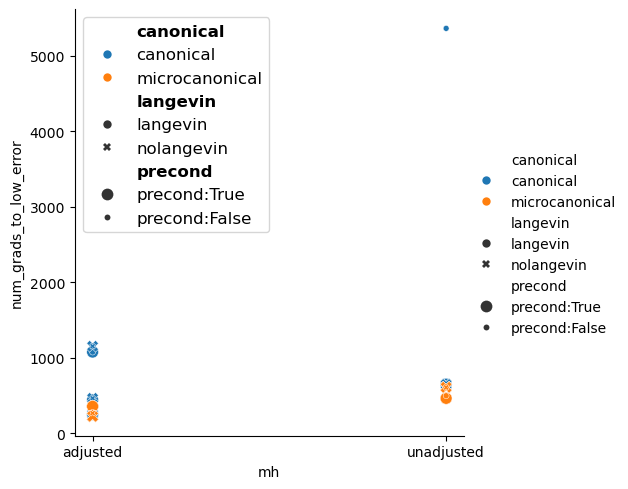

In [6]:
full_results['mh'] = full_results['Sampler'].str.split('_').str[0]
full_results['canonical'] = full_results['Sampler'].str.split('_').str[1]
full_results['langevin'] = full_results['Sampler'].str.split('_').str[2]
full_results['tuning'] = full_results['Sampler'].str.split('_').str[3]
full_results['integrator_type'] = full_results['Sampler'].str.split('_').str[4]
full_results['precond'] = full_results['Sampler'].str.split('_').str[5]
full_results = full_results[full_results['statistic'] == 'square']
full_results = full_results[full_results['max'] == True]

# Filter results for velocity_verlet and mclachlan integrators
verlet_results = full_results[full_results['integrator_type'] == 'velocity_verlet']
mclachlan_results = full_results[full_results['integrator_type'] == 'mclachlan']

# compare verlet and mclachlan results, for square, max: showing num_grads_to_low_error
# Create figure with subplots
# fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# fig.suptitle('Comparison of Velocity Verlet vs Mclachlan Integrators', fontsize=16)

# Plot num_grads_to_low_error for square, max
import seaborn as sns
import matplotlib.pyplot as plt
# hue should be product of canonical and langevin
full_results['canonical_langevin'] = full_results['canonical'].astype(str) + '_' + full_results['langevin'].astype(str)
# without build in legend, add legend manually
sns.relplot(data=full_results, x='mh', y='num_grads_to_low_error', hue='canonical', style='langevin', size='precond', legend=True)

plt.legend(title='', fontsize=12)
for i,text in enumerate(plt.gca().get_legend().get_texts()):
    if i in [0, 3, 6]:
        text.set_fontweight('bold')






